In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qclab.simulation as simulation
from qclab.models.spin_boson import SpinBosonModel
from qclab.drivers.ray_driver import dynamics_parallel_ray

/home/akrotz/Research/pyMQC/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-08 10:02:44,688	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
input_params = dict(temp = 1, V=0.5, E=0.5, A=100, W=0.1, l=0.02/4)
sim = SpinBosonModel(input_params = input_params)

sim.dynamics_method='MF'
sim.sh_deterministic = True # default to sh_deterministic, set num_branches = num_states
sim.num_branches = 1
sim.num_trajs = 2
sim.tmax=int(1/0.0260677)+1
sim.dt=0.01
sim.dt_bath=1/(10*sim.w[-1])
sim.pab_cohere = True
sim.dmat_const = 0
sim.calc_fssh_obs = False
sim.calc_mf_obs = True
sim.gauge_fix = 0

sim.psi_db_0 = np.zeros((sim.num_states),dtype=complex)
sim.psi_db_0[0] = 1

nprocs = 8
num_seeds = 1*sim.num_trajs
seeds = np.arange(0, num_seeds)
data_fssh = dynamics_parallel_ray(sim, seeds, nprocs, simulation.Data())


2024-07-08 10:02:51,048	INFO worker.py:1771 -- Started a local Ray instance.
  0%|          | 0/1 [00:00<?, ?it/s]


RayTaskError(TypeError): [36mray::dynamics_ray()[39m (pid=466131, ip=10.105.232.36)
  File "/home/akrotz/Research/pyMQC/qclab/drivers/ray_driver.py", line 15, in dynamics_ray
    return dynamics.dynamics(sim, simulation.Trajectory(seed))
TypeError: Trajectory.__init__() takes 1 positional argument but 2 were given

: 

[1.12039087 1.12417463 1.13129551 ... 1.03295965 1.0338571  1.03550191]
[188.78989648 188.78611274 188.7789919  ... 188.87743103 188.8765336
 188.87488883]


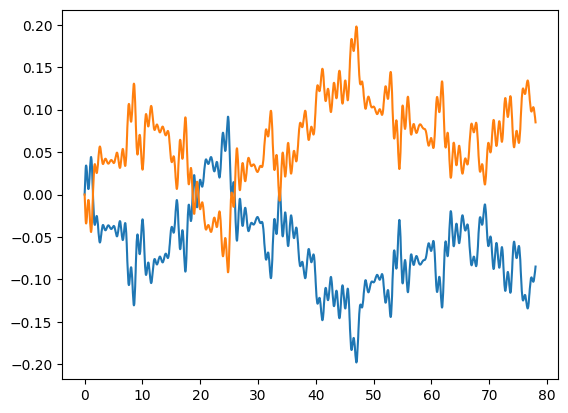

In [ ]:
t = data_fssh.data_dic['t']
eq = data_fssh.data_dic['e_q']
ec = data_fssh.data_dic['e_c']
print(eq)
print(ec)
plt.plot(t, eq-eq[0])
plt.plot(t, ec-ec[0])
plt.show()

In [ ]:
input_params = dict(temp = 1, V=0.5, E=0.5, A=100, W=0.1, l=0.02/4)
sim = SpinBosonModel(input_params = input_params)
sim.dynamics_method='CFSSH'
sim.num_branches = 2
sim.num_trajs = 10
sim.tmax=int(1/0.0260677)+1
sim.dt=0.01
sim.dt_bath=1/(10*sim.w[-1])
sim.sh_deterministic = True
sim.pab_cohere = False
sim.dmat_const = 0
sim.calc_cfssh_obs = True
sim.calc_mf_obs = False
sim.gauge_fix = 0

sim.psi_db_0 = np.zeros((sim.num_states),dtype=complex)
sim.psi_db_0[0] = 1

nprocs = 8
num_seeds = 200*sim.num_trajs
seeds = np.arange(0, num_seeds)
data_cfssh0 = dynamics_parallel_ray(sim, seeds, nprocs, simulation.Data())

2024-07-06 22:07:14,377	INFO worker.py:1771 -- Started a local Ray instance.
  0%|          | 0/26 [00:00<?, ?it/s](raylet) [2024-07-06 22:08:14,283 E 2570133 2570133] (raylet) node_manager.cc:3064: 11 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 6d29f2e4a04d06d86dcecbefc5c5c2ec7652feb997f92297ed72908a, IP: 192.168.0.3) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.0.3`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.

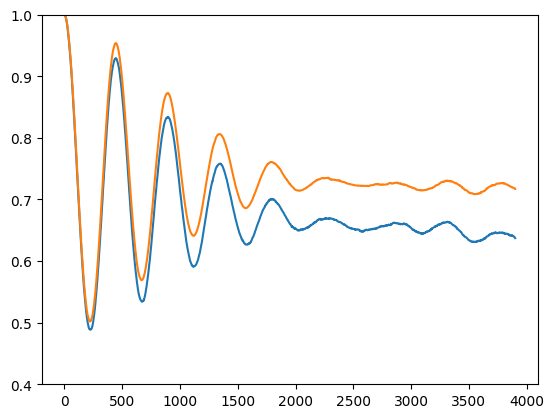

In [ ]:
pops_fssh = np.real(np.einsum('nii->ni',data_fssh.data_dic['rho_db_fssh']))
ntraj = np.sum(pops_fssh[0])
pops_fssh = pops_fssh/ntraj

pops_cfssh0 = np.real(np.einsum('nii->ni',data_cfssh0.data_dic['rho_db_cfssh']))
ntraj = np.sum(pops_cfssh0[0])
pops_cfssh0 = pops_cfssh0/ntraj

#pops_cfssh1 = np.real(np.einsum('nii->ni',data_cfssh1.data_dic['rho_db_cfssh']))
#ntraj = np.sum(pops_cfssh1[0])
#pops_cfssh1 = pops_cfssh1/ntraj

plt.plot(pops_fssh[:,0])
plt.plot(pops_cfssh0[:,0])
#plt.plot(pops_cfssh1[:,0])
plt.ylim([0.4,1])
plt.show()